In [1]:
import joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
rf = joblib.load('rf_model_4.pkl')

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("SDOH_Filtered_Data_Per_Capita.csv")
df = df.drop('STATE', axis = 1)
df = df.drop('COUNTY', axis = 1)
df = df.sort_values(['COUNTYFIPS','YEAR'])

In [4]:
df_county_codes = df["COUNTYFIPS"]
df_county_codes.drop_duplicates(inplace = True)

In [5]:
df_counties = {}
for county in df["COUNTYFIPS"].unique():
    df_counties[str(county)] = df[df["COUNTYFIPS"] == county]

In [6]:
import scipy
from scipy.interpolate import interp1d
import pylab as P
from collections import defaultdict

f = defaultdict(list)
for df_county in df_counties:
    for variable in df_counties[df_county].columns:
        if (variable == "CDCA_HEART_DTH_RATE_ABOVE35" or variable == "YEAR" or variable == "COUNTYFIPS" or variable == "STATEFIPS"):
            continue
        f[df_county].append(scipy.interpolate.interp1d(df_counties[df_county].YEAR, df_counties[df_county][variable], kind = "linear", fill_value='extrapolate'))

In [13]:
def get_extrapolated_data (countyFIPS, stateFIPS, year, changeValue = False, columnToChange = "", changeBy = 0):
    variable_sign = [1, 1,-1,-1,-1,-1,1,-1,1,1,1,1,1,1,1,1,1]
    if (type(year) == int):
        countyFIPS = str(int(countyFIPS))
        stateFIPS = str(int(stateFIPS))
        dfx = pd.DataFrame()
        values = [year, countyFIPS, stateFIPS]
        ind = 0
        find = 0
        while (ind < len(df.columns)):
            variable = df.columns[ind]
            if (variable == "CDCA_HEART_DTH_RATE_ABOVE35" or variable == "YEAR" or variable == "COUNTYFIPS" or variable == "STATEFIPS"):
                ind += 1
                continue
            offset = 0
            if (changeValue and variable == columnToChange):
                offset = float(f[countyFIPS][find](year)) *  changeBy * variable_sign[find] / 100
            values.append(float(f[countyFIPS][find](year)) + offset)
            ind += 1
            find += 1
        dfx = dfx.append(pd.Series(values), ignore_index = True)
        return dfx
    elif (type(year) == list):
        dfx = pd.DataFrame()
        countyFIPS = str(int(countyFIPS))
        stateFIPS = str(int(stateFIPS))
        for y in range (year[0], year[1] + 1):
            values = [y, countyFIPS, stateFIPS]
            ind = 0
            find = 0
            while (ind < len(df.columns)):
                variable = df.columns[ind]
                if (variable == "CDCA_HEART_DTH_RATE_ABOVE35" or variable == "YEAR" or variable == "COUNTYFIPS" or variable == "STATEFIPS"):
                    ind += 1
                    continue
                offset = 0
                if (changeValue and variable == columnToChange):
                    offset = float(f[countyFIPS][find](y)) *  changeBy  * variable_sign[find] / 100
                values.append(float(f[countyFIPS][find](y)) + offset)
                ind += 1
                find += 1
            dfx[y] = pd.Series(values)
        return dfx.transpose()

In [14]:
import numpy as np
top_variables = np.load('2024_forecast_county_2.npy', allow_pickle = True)
top_variables = dict(enumerate(top_variables.flatten(), 1))[1]

In [20]:
import matplotlib.pyplot as plt
def generate_plot (years, countyfips):
    statefips = countyfips[0:2]
    forecast = rf.predict(get_extrapolated_data(countyfips, statefips, years, False))
    changed1 = rf.predict(get_extrapolated_data(countyfips, statefips, years, True, top_variables[str(int(countyfips))][0][0], 10))
    changed2 = rf.predict(get_extrapolated_data(countyfips, statefips, years, True, top_variables[str(int(countyfips))][0][1], 10))
    changed3 = rf.predict(get_extrapolated_data(countyfips, statefips, years, True, top_variables[str(int(countyfips))][0][2], 10))
    plt.figure(dpi=400)
    plt.plot(df[df.COUNTYFIPS == int(countyfips)].YEAR, df[df.COUNTYFIPS == int(countyfips)].CDCA_HEART_DTH_RATE_ABOVE35, color = "blue")
    plt.plot(list(range(years[0], years[1] + 1)), changed1, color = "orange", linestyle='dashed')
    plt.plot(list(range(years[0], years[1] + 1)), changed2, color = "purple", linestyle='dashed')
    plt.plot(list(range(years[0], years[1] + 1)), changed3, color = "green", linestyle='dashed')
    plt.plot(list(range(years[0], years[1] + 1)), forecast, color = "red", linestyle='dashed')
    plt.title(countyfips + " Cardiovascular Disease Death Rate Over Time")
    
    ax = plt.gca()
    improved = " improved"
    ax.legend(('actual', top_variables[str(int(countyfips))][0][0] + improved, top_variables[str(int(countyfips))][0][1] + improved, top_variables[str(int(countyfips))][0][2] + improved, 'forecast'))
    ax.set_ylim([min(forecast) - 50, max(forecast) + 150])

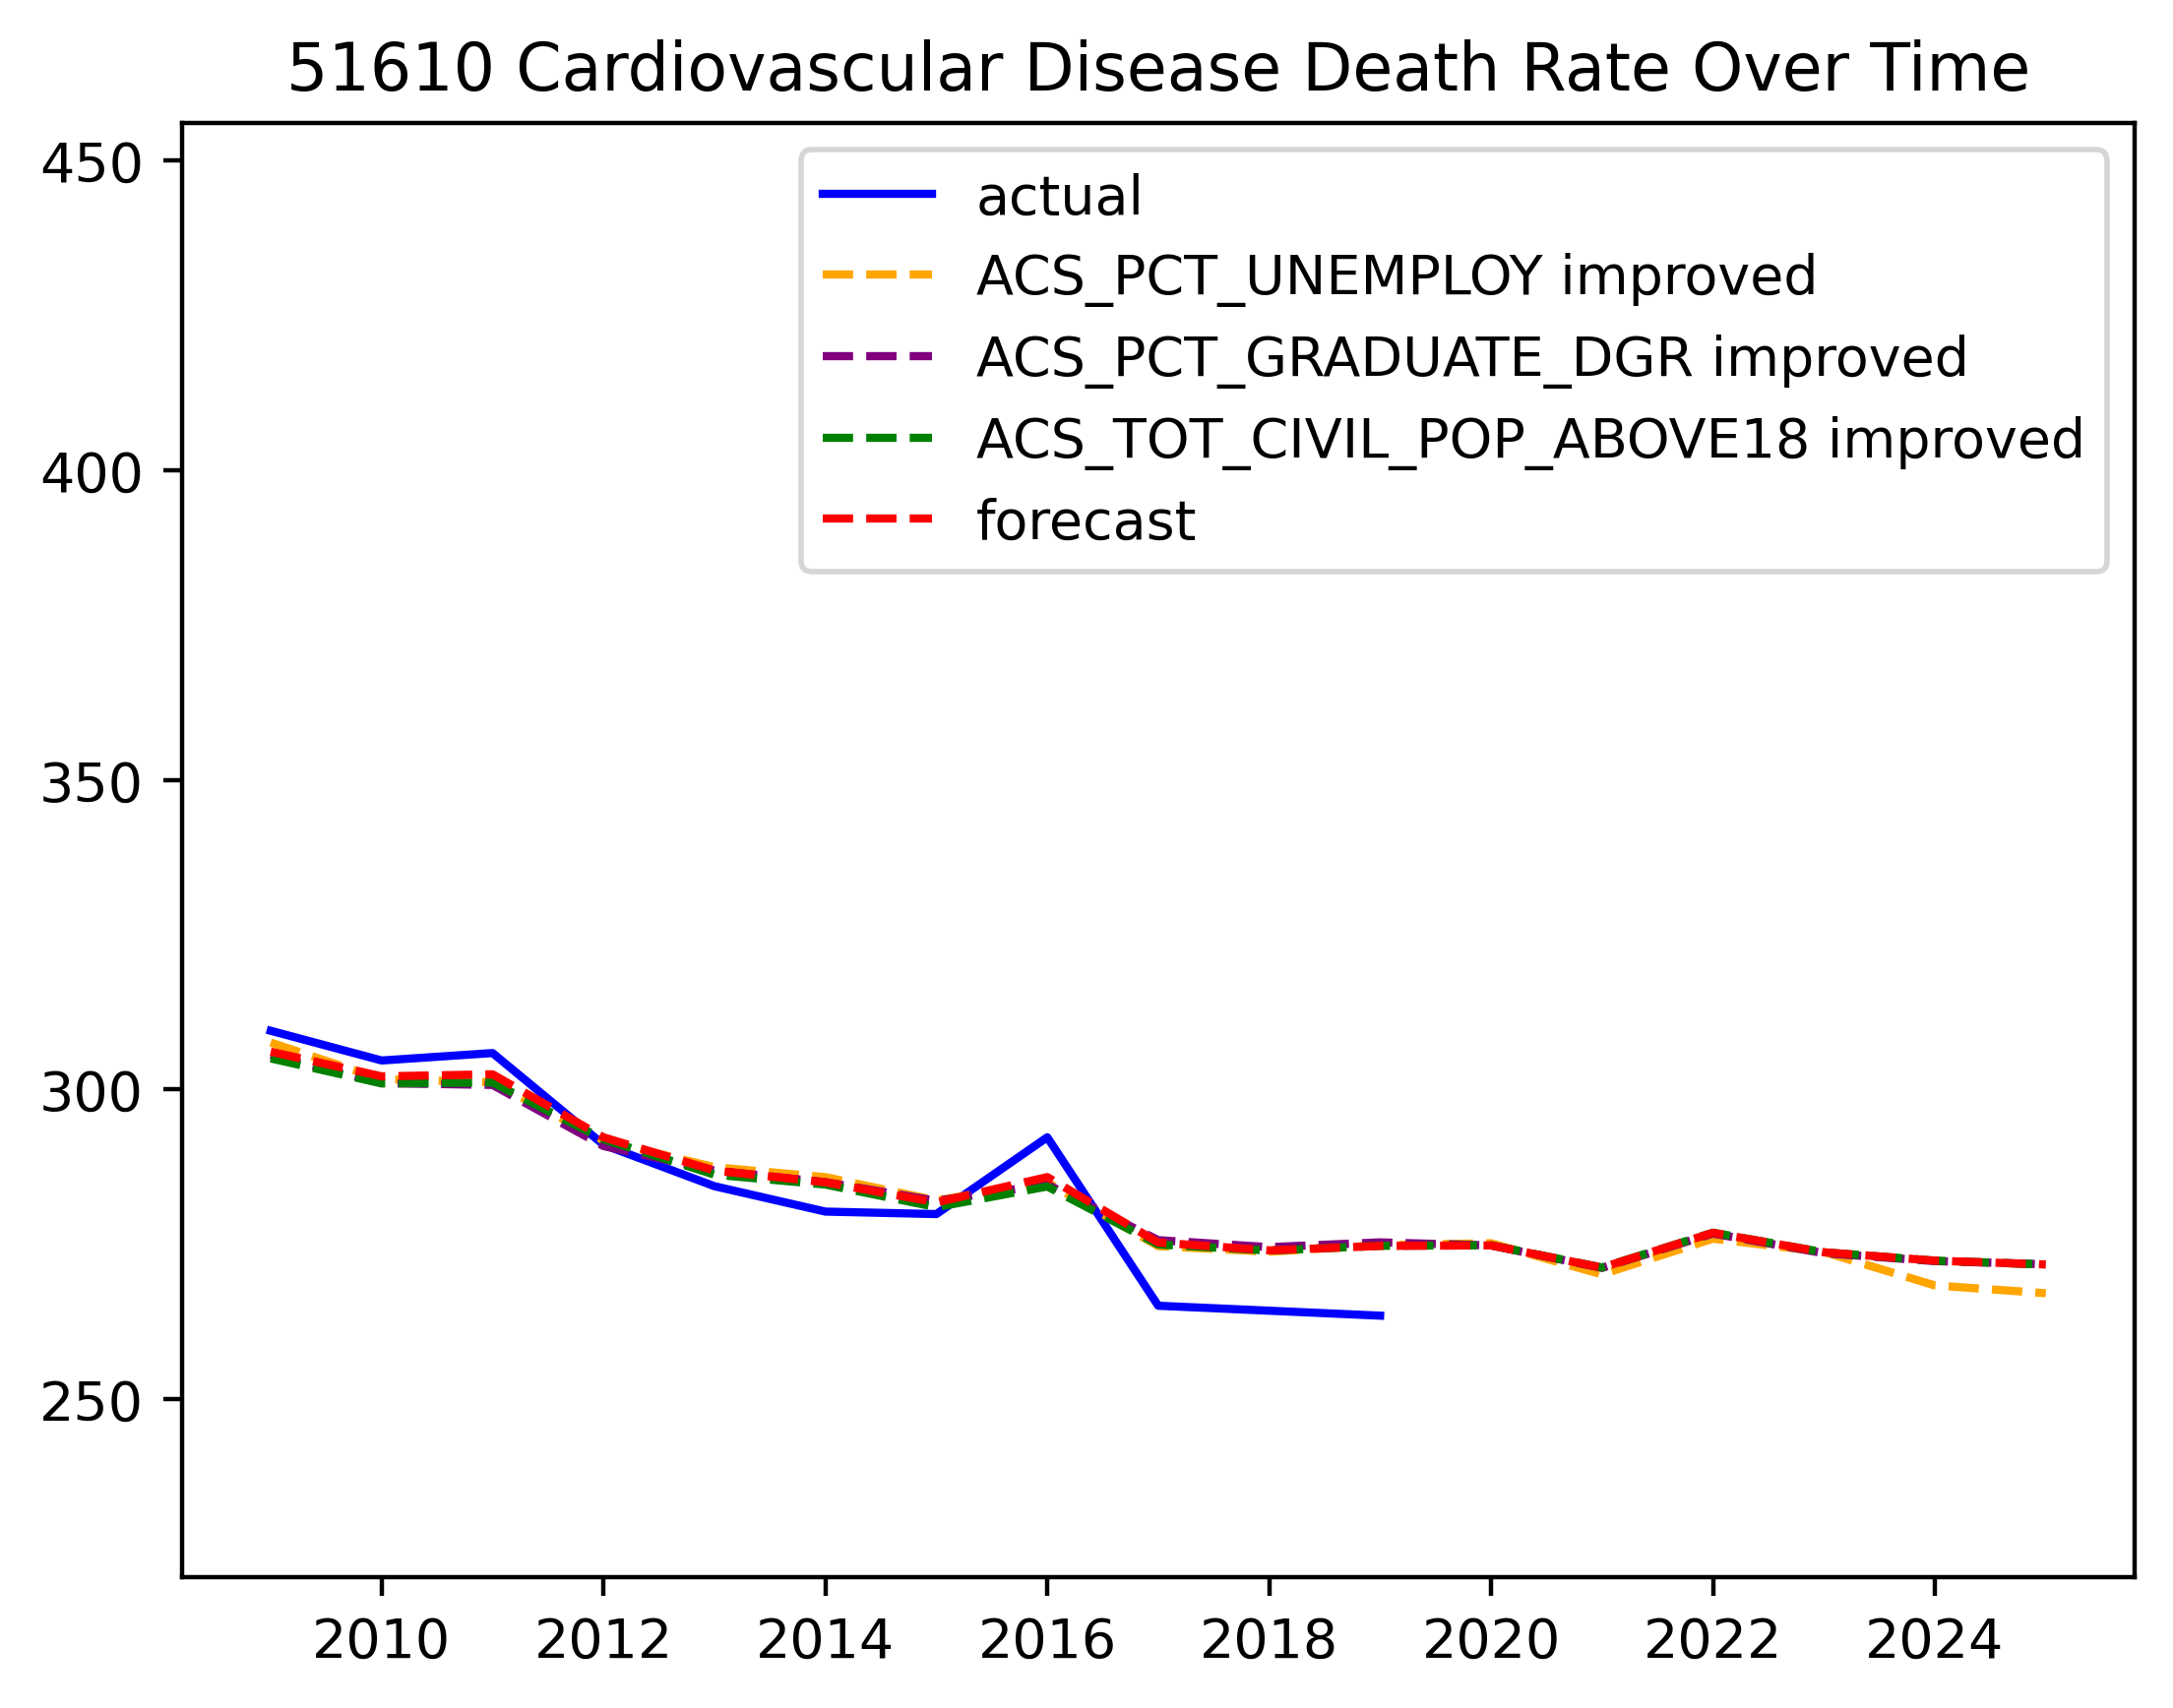

In [37]:
generate_plot ([2009, 2025], "51610")

In [23]:
def get_top_variables (year, countyfips, num_top_variables):
    chosen_year = year
    best_variables = {}
    chosen_year_forecast = {}
    code = str(countyfips)
    variables = df.columns
    forecast_df = get_extrapolated_data (code, code[0:-3], 2024, False)
    chosen_year_forecast[code] = rf.predict(forecast_df)[0]
    for variable in variables:
        extrap_df = get_extrapolated_data (code, code[0:-3], chosen_year, True, variable, 10)
        forecast_pred = rf.predict(extrap_df)
        year = 2024
        for pred in forecast_pred:
            if year == chosen_year:
                best_variables[variable] = float(pred)
    #         print ("Year: " + str(year) + " Death Rate: " + str(float(pred)))
            year += 1
    keys = list(best_variables.keys())
    values = list(best_variables.values())
    sorted_value_index = np.argsort(values)
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    print (code, end = ' ')
    print (chosen_year_forecast[code], end= ' ')
    print(list(sorted_dict.keys())[0:num_top_variables], list(sorted_dict.values())[0:num_top_variables])
#     top_variables[code].append(list(sorted_dict.keys())[0:3])
#     top_variables[code].append(list(sorted_dict.values())[0:3])

In [24]:
get_top_variables (2024, "06081", 7)

06081 276.89919999999984 ['ACS_PCT_POSTHS_ED', 'ACS_PCT_HS_GRADUATE', 'ACS_PCT_GRADUATE_DGR', 'AHRF_TOT_ST_G_HOSP_BED', 'AHRF_TOT_HOSPS', 'AHRF_TOT_STNG_LT_HOSP_ADMS', 'ACS_PCT_UNEMPLOY'] [260.7822000000007, 273.4881, 276.76589999999993, 276.79689999999977, 276.81419999999986, 276.83299999999986, 276.89809999999983]


In [19]:
get_top_variables (2024, "06085", 7)

06085 273.70010000000104 ['ACS_PCT_POSTHS_ED', 'ACS_PCT_LT_HS', 'ACS_PCT_GRADUATE_DGR', 'ACS_PCT_HS_GRADUATE', 'AHRF_TOT_ST_G_HOSP_ADMS', 'AHRF_TOT_OUTPAT_VST_STNGH', 'AHRF_TOT_NH_BED_STNGH'] [258.19800000000214, 272.64500000000106, 273.158100000001, 273.29400000000095, 273.67860000000115, 273.683700000001, 273.70010000000104]
